In [22]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.linalg import block_diag
from utils import get_form_initial_conditions
from unkkt import UNKKT
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

In [23]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]
dynamic_model = SatelliteDynamics()

In [24]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [25]:
# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
# mm_newton.grad_tol = 1e-2
# mm_newton.mm_tol = 1e-6
# mm_newton.mm_max_iter = 20

In [26]:
# Fixed seed for reproducibility
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

Windows:   0%|          | 0/296 [00:00<?, ?it/s]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 2766622318.644657
Grad_L_norm = 75892924530.26878

Iteration 1
L_norm = 38267594.479701936
Grad_L_norm = 455267164.17664945

Iteration 2
L_norm = 1624287.7738636588
Grad_L_norm = 59146943.40445968

Iteration 3
L_norm = 260420.98421246783
Grad_L_norm = 5054853.761193565

Iteration 4
L_norm = 38070.40881469271
Grad_L_norm = 2117924.1842241352

Iteration 5
L_norm = 2221.730325444241
Grad_L_norm = 605946.4068298418

Iteration 6
L_norm = 441.61784677902307
Grad_L_norm = 30514.211881499534

Iteration 7
L_norm = 438.1432949244704
Grad_L_norm = 45.68649739071609

Iteration 8
L_norm = 438.1432801357723
Grad_L_norm = 2.7727353185537624

STOP on Iteration 9
L_norm = 438.1432802659756
Grad_L_norm = 0.19962881489779202

Final position relative errors: 0.03811004095522775 m, 0.27811873678814125 m, 0.37695708910751363 m, 0.40364910088914074 m
-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 276662

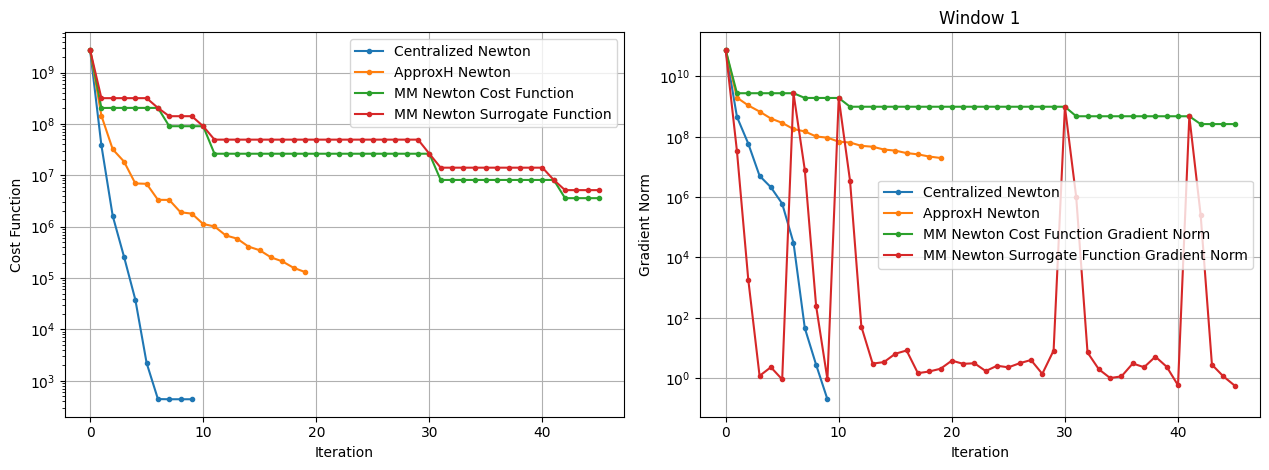


Windows:   0%|          | 1/296 [03:05<15:09:38, 185.01s/it]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 433.49885252797617
Grad_L_norm = 34119.69076783629

Iteration 1
L_norm = 432.75728444507774
Grad_L_norm = 4.037540648943026

Iteration 2
L_norm = 432.7572841976981
Grad_L_norm = 4.627185235523096

Iteration 3
L_norm = 432.75728467319755
Grad_L_norm = 6.313199318434836

Iteration 4
L_norm = 432.7572839503131
Grad_L_norm = 8.05940593218516

STOP on Iteration 5
L_norm = 432.7572840053889
Grad_L_norm = 0.8143017253136968

Final position relative errors: 0.037928576748836124 m, 0.36294162909409583 m, 0.5021181105685347 m, 0.46176806393351694 m
-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 129150.47022950275
Gradient norm: 18483891.88985619
Global relative error: 266.81427865273423
Position relative errors: 0.11513951903164538 m, 147.80183451250238 m, 175.36753425364375 m, 136.34764410220367 m

Iteration 1
Cost function: 100039.60683410607 (-22.54%)
Gradient norm: 16066152.654900476 (-

In [ ]:
# Main execution loop
for m in tqdm(range(M), desc="MC runs", leave=True):
    # Observations
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

    # Estimate the state
    X_est_unkkt = X_initial + initial_dev
    X_est_approx_newton = X_initial + initial_dev
    X_est_mm = X_initial + initial_dev
    for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
        print("-------- Centralized Newton --------")
        X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n : n + W])
        print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n] - X_est_unkkt[18:21])} m")
        print("-------- ApproxH Newton --------")
        X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n : n + W], X_true[:, :, n])
        print("-------- MM Newton --------")
        X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n : n + W], X_true[:, :, n])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

        # First subplot - Cost function values
        ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
        ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
        ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
        ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Cost Function')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        # Second subplot - Gradient norm values
        ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
        ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
        ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
        ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.legend()

        plt.title(f'Window {n + 1}')
        plt.tight_layout()
        plt.show()
        
        unkkt.cost_function_values = []
        unkkt.grad_norm_values = []
        approxh_newton.cost_function_values = []
        approxh_newton.grad_norm_values = []
        mm_newton.cost_function_values = []
        mm_newton.grad_norm_values = []
        mm_newton.surrogate_function_values = []
        mm_newton.surrogate_grad_norm_values = []
        
        X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
        X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
        X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)